<p style="font-size: 30px; text-align: center;"><b>Deep Learning (CS F423) Term Project</b></p>
<p style="font-size: 24px; text-align: center;">Skin Cancer Classification </p>

# Model 1

In [1]:
import os
import copy
import time
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [2]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torchvision.io import read_image
torch.manual_seed(0)

from google.colab import drive
drive.mount('/content/drive')

## Data Loading

In [3]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        labels = []
        paths = []
        for file_name in os.listdir(img_dir):
            labels.append(int(file_name.split('_')[0]) - 1)
            paths.append(os.path.join(img_dir, file_name))
        
        self.img_labels = pd.DataFrame([paths, labels]).T
        del labels
        del paths

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label   

In [4]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset, weights=None):
        self.dataset = dataset
        self.weights = np.array(weights)
        self.transform = dataset.transform
        self.target_transform = dataset.target_transform
        self.num_classes = len(self.dataset.img_labels[1].unique())
        
        if weights is None:
            self.weights = np.ones(self.num_classes, dtype=np.int8)
        if len(self.weights) != self.num_classes:
            raise ValueError("Expected {} weights. Provided {}. len(weights) should be equal to number of classes".
                             format(self.num_classes, len(self.weights)))

        labels = []
        paths = []
        df = self.dataset.img_labels
        for fpath, label in df.itertuples(index=False):
            for _ in range(self.weights[label]):
                paths.append(fpath)
                labels.append(label)
        
        self.img_labels = pd.DataFrame([paths, labels]).T

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
weights = models.MobileNet_V3_Large_Weights.IMAGENET1K_V2

# We are converting into RGB format as MobileNet expects 3 channel images.
data_transforms = {"train" : transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation(degrees=20),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        weights.transforms()
    ]),
    "val" : transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        weights.transforms()
    ])
}

In [6]:
train_path = "/content/drive/MyDrive/train"
val_path = "/content/drive/MyDrive/val"

train_imgDataset = ImageDataset(img_dir=train_path, transform=data_transforms["train"])
valid_imgDataset = ImageDataset(img_dir=val_path, transform=data_transforms["val"])

In [7]:
train_imgDataset.img_labels[1].value_counts(sort=False)

1
0     112
1     148
2     343
3      36
4     253
5    2073
6      35
Name: count, dtype: int64

In [8]:
valid_imgDataset.img_labels[1].value_counts(sort=False)

1
0     36
1     60
2    102
3     15
4     97
5    670
6     20
Name: count, dtype: int64

In [8]:
print(len(train_imgDataset), len(valid_imgDataset))

3000 1000


In [9]:
label_weights = [4,4,2,6,2,1,6]
train_dataset = AugmentedDataset(train_imgDataset, weights=label_weights)
valid_dataset = AugmentedDataset(valid_imgDataset)

In [10]:
print(len(train_dataset), len(valid_dataset))

4731 1000


In [11]:
# train_dataset.img_labels.to_csv("AugmentedTrain.csv", index=False)
train_dataset.img_labels.iloc[2]

0    train\1_image_1014.jpg
1                         0
Name: 2, dtype: object

In [17]:
train_dataset.img_labels[1].value_counts(sort=False)

1
0     448
1     592
2     686
3     216
4     506
5    2073
6     210
Name: count, dtype: int64

In [12]:
train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=25, shuffle=True)
len(train_loader)

95

In [13]:
def imshow_(inp, title=None):
    inp = inp.permute(1, 2, 0).numpy()       # Permutes the dimensions of the image.
    inp = (inp - inp.min()) / (inp.max() - inp.min())
    print(inp.shape)
    
    plt.imshow(inp[:,:,0], cmap="gray")
    if title is not None:
        plt.title(title)
    # plt.pause(0.1)
    plt.show()

(224, 224, 3)


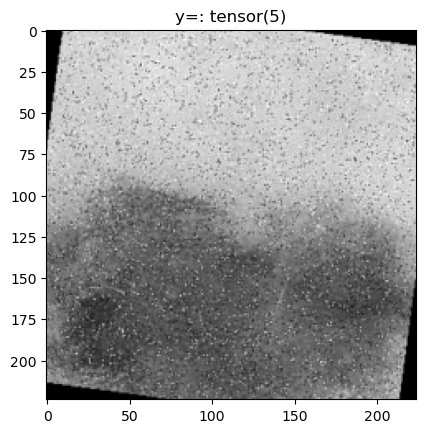

(224, 224, 3)


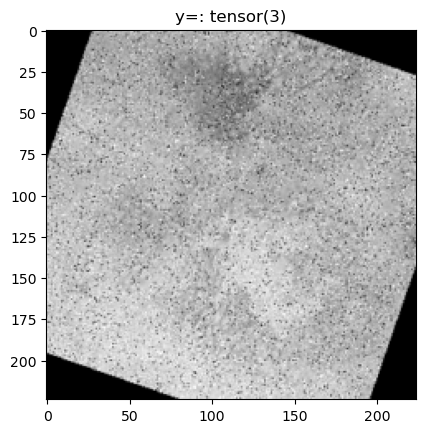

(224, 224, 3)


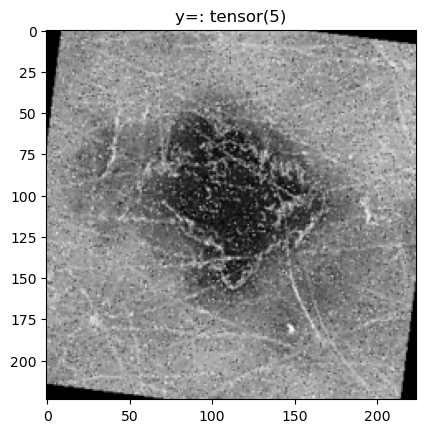

In [14]:
for x,y  in train_loader:
    for i in range(len(y)):
        imshow_(x[i],"y=: {}".format(str(y[i])))
        if i==2:
            break
    break

In [15]:
for images, labels in train_loader:
    print(images.shape, labels)
    break

torch.Size([50, 3, 224, 224]) tensor([4, 5, 1, 5, 5, 2, 4, 2, 5, 5, 5, 4, 5, 0, 4, 4, 1, 1, 5, 5, 5, 1, 1, 2,
        5, 5, 5, 2, 5, 0, 5, 5, 5, 5, 2, 1, 6, 5, 5, 5, 5, 0, 1, 4, 6, 2, 5, 0,
        5, 0])


## Training Model 1

### Hyperparameters

In [15]:
n_epochs = 12
batch_size = 50
lr = 0.0005
n_classes = 7
momentum = 0.9

In [16]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=25, shuffle=True)

In [17]:
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The device type is:", device)

The device type is: cpu


In [19]:
for param in model.parameters():
    param.requires_grad = False

In [20]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

<b> NOTE: We can change the architecture by changing the parameters in the last layer </b>

In [21]:
model.features[16] = models.mobilenetv3.Conv2dNormActivation(
    in_channels = 160,
    out_channels = 800,
    kernel_size = 1,
    stride = 1,
    bias = False,
    # norm_layer = functools.partial(nn.BatchNorm2d, eps=0.001, momentum=0.01),
    activation_layer=lambda *args, **kwargs: nn.Hardswish()
)

model.classifier = nn.Sequential(
    nn.Linear(in_features=800, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1280, out_features=n_classes, bias=True)
)

In [22]:
model.features[16]

Conv2dNormActivation(
  (0): Conv2d(160, 800, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Hardswish()
)

In [23]:
model = model.to(device)

In [24]:
class_weights = torch.Tensor(1/train_dataset.img_labels[1].value_counts(sort=False, normalize=True))
class_weights/class_weights.min()


tensor([4.6272, 3.5017, 3.0219, 9.5972, 4.0968, 1.0000, 9.8714])

In [25]:
class_weights = torch.Tensor([3, 2.2, 2, 5, 3, 1, 5])
class_weights = class_weights.to(device)
print(class_weights)

tensor([3.0000, 2.2000, 2.0000, 5.0000, 3.0000, 1.0000, 5.0000])


### Training only last 2 layers

In [26]:
criterion1 = nn.CrossEntropyLoss(weight=class_weights)
"""
optimizer1 = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer1 = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler1 = lr_scheduler.StepLR(optimizer1, step_size=3, gamma=0.5)
scheduler1 = lr_scheduler.CyclicLR(optimizer1, base_lr=0.1, max_lr=0.3,step_size_up=5,mode="triangular2")
scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer1, mode='max', factor=0.5, patience=2)
"""
optimizer1 = torch.optim.Adam(model.parameters(), lr=lr)
scheduler1 = lr_scheduler.StepLR(optimizer1, step_size=3, gamma=0.5)

In [27]:
def train_model(model, train_loader,validation_loader, criterion, optimizer, n_epochs, scheduler=None, print_=True):
    loss_list = []
    accuracy_list = []
    models_list = []
    correct = 0
    n_test = len(validation_loader.dataset)
    accuracy_best=0
    train_cost_best = 2
    best_model_wts = copy.deepcopy(model.state_dict())

    # Loop through epochs
    for epoch in range(n_epochs):
        loss_sublist = []
        model.train()
        
        if print_:
            print(f"Learning rate for epoch {epoch+1}:", optimizer.param_groups[0]['lr'])
            
        # Loop through the data in loader
        for x, y in tqdm(train_loader):
            x, y=x.to(device), y.to(device)
            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_cost = np.mean(loss_sublist)
        loss_list.append(train_cost)
        
        correct = 0
        model.eval()
        print("Fetching validation results for epoch {} ...".format(epoch+1))

        with torch.no_grad():
            for x_test, y_test in validation_loader:
                x_test, y_test=x_test.to(device), y_test.to(device)
                z = model(x_test)
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == y_test).sum().item()
            accuracy = correct / n_test
            accuracy_list.append(accuracy)
        
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(accuracy)
            else:
                scheduler.step()
        
        if accuracy>accuracy_best:
            accuracy_best = accuracy
            train_cost_best = train_cost
            best_model_wts = copy.deepcopy(model.state_dict())
        elif accuracy == accuracy_best and train_cost < train_cost_best:
            train_cost_best = train_cost
            best_model_wts = copy.deepcopy(model.state_dict())
      
        if print_:
            print("The training cost for epoch " + str(epoch + 1) + ": " + str(train_cost))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy))
            print()
        models_list.append(copy.deepcopy(model.state_dict()))
    model.load_state_dict(best_model_wts)
    return accuracy_list, loss_list, model, models_list

In [28]:
start_datetime = datetime.now()
start_time=time.time()
print("Training started at:", datetime.now())

accuracy_list,loss_list, model, mod_list = train_model(model,train_loader , valid_loader, criterion1, optimizer1, scheduler=scheduler1, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("Elapsed time", elapsed_time )

Training started at: 2025-04-13 23:29:48.467184
Learning rate for epoch 1: 0.0005


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [02:28<00:00,  1.56s/it]


Fetching validation results for epoch 1 ...
The training cost for epoch 1: 1.5473805804001657
The validation accuracy for epoch 1: 0.668

Learning rate for epoch 2: 0.0005


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [01:58<00:00,  1.24s/it]


Fetching validation results for epoch 2 ...
The training cost for epoch 2: 1.3452378875330875
The validation accuracy for epoch 2: 0.623

Learning rate for epoch 3: 0.0005


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [01:58<00:00,  1.24s/it]


Fetching validation results for epoch 3 ...
The training cost for epoch 3: 1.3056125465192292
The validation accuracy for epoch 3: 0.643

Learning rate for epoch 4: 0.00025


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [01:58<00:00,  1.25s/it]


Fetching validation results for epoch 4 ...
The training cost for epoch 4: 1.2773573291929146
The validation accuracy for epoch 4: 0.626

Learning rate for epoch 5: 0.00025


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [02:05<00:00,  1.32s/it]


Fetching validation results for epoch 5 ...
The training cost for epoch 5: 1.2588843960511058
The validation accuracy for epoch 5: 0.593

Learning rate for epoch 6: 0.00025


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [02:07<00:00,  1.34s/it]


Fetching validation results for epoch 6 ...
The training cost for epoch 6: 1.2313891862568103
The validation accuracy for epoch 6: 0.58

Learning rate for epoch 7: 0.000125


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [02:07<00:00,  1.34s/it]


Fetching validation results for epoch 7 ...
The training cost for epoch 7: 1.2238981893188075
The validation accuracy for epoch 7: 0.519

Learning rate for epoch 8: 0.000125


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [02:10<00:00,  1.37s/it]


Fetching validation results for epoch 8 ...
The training cost for epoch 8: 1.2039402403329549
The validation accuracy for epoch 8: 0.554

Learning rate for epoch 9: 0.000125


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [02:04<00:00,  1.31s/it]


Fetching validation results for epoch 9 ...
The training cost for epoch 9: 1.1995947273154008
The validation accuracy for epoch 9: 0.553

Learning rate for epoch 10: 6.25e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [02:01<00:00,  1.28s/it]


Fetching validation results for epoch 10 ...
The training cost for epoch 10: 1.18949634589647
The validation accuracy for epoch 10: 0.626

Learning rate for epoch 11: 6.25e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [02:01<00:00,  1.28s/it]


Fetching validation results for epoch 11 ...
The training cost for epoch 11: 1.2106024535078752
The validation accuracy for epoch 11: 0.622

Learning rate for epoch 12: 6.25e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [01:59<00:00,  1.25s/it]


Fetching validation results for epoch 12 ...
The training cost for epoch 12: 1.175192181687606
The validation accuracy for epoch 12: 0.642

Elapsed time 1707.0308482646942


In [29]:
def evaluate(model, dataloader, class_names, title):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

    # Compute classification metrics
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    tot_acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

    print("\nClassification Report:")
    print(f"Total accuracy: {tot_acc}\n")
    print(pd.DataFrame([class_accuracy, precision, recall, f1], columns=class_names, index=["Accuracy", "Precision", "Recall", "F1-Score"]).T)

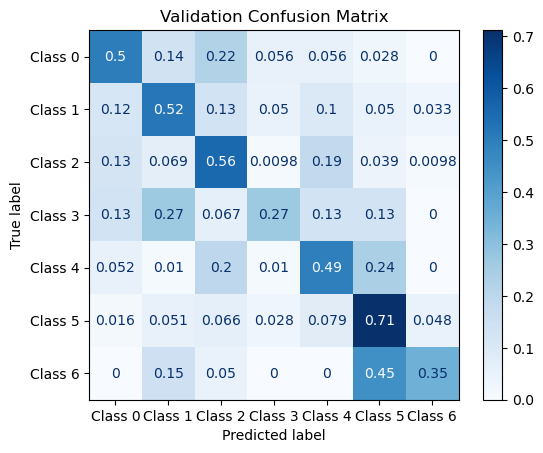


Classification Report:
Total accuracy: 0.642

         Accuracy  Precision    Recall  F1-Score
Class 0  0.500000   0.321429  0.500000  0.391304
Class 1  0.516667   0.364706  0.516667  0.427586
Class 2  0.558824   0.413043  0.558824  0.475000
Class 3  0.266667   0.133333  0.266667  0.177778
Class 4  0.494845   0.369231  0.494845  0.422907
Class 5  0.711940   0.919075  0.711940  0.802355
Class 6  0.350000   0.166667  0.350000  0.225806


In [52]:
model.load_state_dict(mod_list[-1])
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, valid_loader, class_names, title="Validation Confusion Matrix")

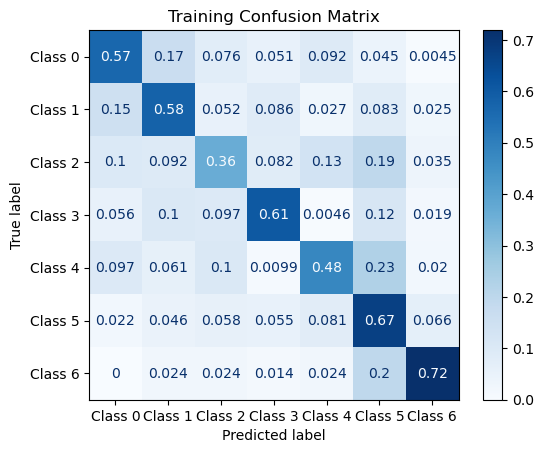


Classification Report:
Total accuracy: 0.5838089198900867

         Accuracy  Precision    Recall  F1-Score
Class 0  0.566964   0.491296  0.566964  0.526425
Class 1  0.579392   0.541009  0.579392  0.559543
Class 2  0.362974   0.485380  0.362974  0.415346
Class 3  0.606481   0.341146  0.606481  0.436667
Class 4  0.478261   0.429078  0.478261  0.452336
Class 5  0.671491   0.783784  0.671491  0.723305
Class 6  0.719048   0.440233  0.719048  0.546112


In [31]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, train_loader, class_names, title="Training Confusion Matrix")

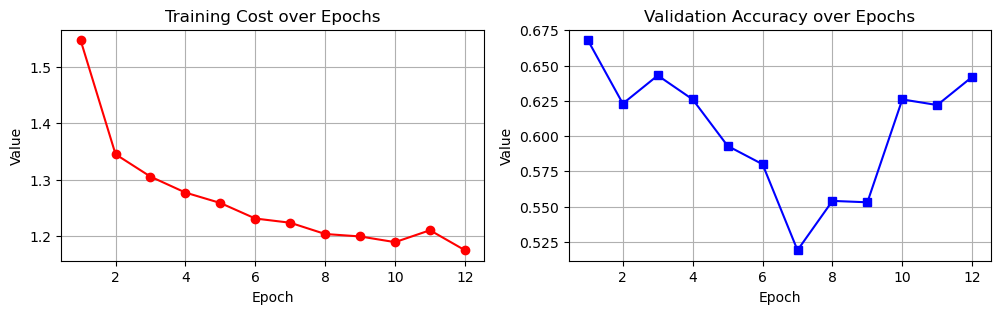

In [34]:
epochs_r = range(1, n_epochs+1)
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(epochs_r, loss_list, marker='o', label='Training Cost', color='red')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Cost over Epochs')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs_r, accuracy_list, marker='s', label='Validation Accuracy', color='blue')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Fine Tuning Model 1

In [70]:
model.load_state_dict(mod_list[-1])
for param in model.parameters():
    param.requires_grad = True

In [71]:
class_weights = torch.Tensor([3, 2.2, 2, 7, 3, 1, 5])
class_weights = class_weights.to(device)

train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=25, shuffle=True)

In [60]:
criterion2 = nn.CrossEntropyLoss(weight=class_weights)
optimizer2 = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer2 = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler2 = lr_scheduler.StepLR(optimizer2, step_size=2, gamma=0.5)

start_datetime = datetime.now()
start_time=time.time()
print("Training started at:", datetime.now())

accuracy_list2,loss_list2, model, mod_list2 = train_model(model,train_loader , valid_loader, criterion2, optimizer2, scheduler=scheduler2, n_epochs=6)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("Elapsed time", elapsed_time )

Training started at: 2025-04-14 02:30:53.345525
Learning rate for epoch 1: 0.0005


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [03:54<00:00,  2.46s/it]


Fetching validation results for epoch 1 ...
The training cost for epoch 1: 1.036588444207844
The validation accuracy for epoch 1: 0.684

Learning rate for epoch 2: 0.0005


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [03:59<00:00,  2.52s/it]


Fetching validation results for epoch 2 ...
The training cost for epoch 2: 0.7508805350253457
The validation accuracy for epoch 2: 0.661

Learning rate for epoch 3: 0.00025


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [04:00<00:00,  2.54s/it]


Fetching validation results for epoch 3 ...
The training cost for epoch 3: 0.5629768782540372
The validation accuracy for epoch 3: 0.755

Learning rate for epoch 4: 0.00025


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [04:00<00:00,  2.53s/it]


Fetching validation results for epoch 4 ...
The training cost for epoch 4: 0.47443062819932635
The validation accuracy for epoch 4: 0.717

Learning rate for epoch 5: 0.000125


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [04:01<00:00,  2.54s/it]


Fetching validation results for epoch 5 ...
The training cost for epoch 5: 0.3701386144286708
The validation accuracy for epoch 5: 0.738

Learning rate for epoch 6: 0.000125


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [03:56<00:00,  2.49s/it]


Fetching validation results for epoch 6 ...
The training cost for epoch 6: 0.3096485679086886
The validation accuracy for epoch 6: 0.72

Elapsed time 1512.4398226737976


In [ ]:
model.load_state_dict(mod_list2[2])
# torch.save(model.state_dict(), "models_revamped/model_large_755Adam.pt")

<All keys matched successfully>

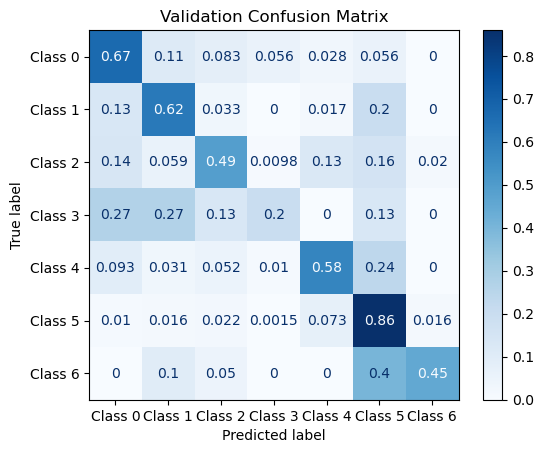


Classification Report:
Total accuracy: 0.755

         Accuracy  Precision    Recall  F1-Score
Class 0  0.666667   0.363636  0.666667  0.470588
Class 1  0.616667   0.552239  0.616667  0.582677
Class 2  0.490196   0.641026  0.490196  0.555556
Class 3  0.200000   0.375000  0.200000  0.260870
Class 4  0.577320   0.466667  0.577320  0.516129
Class 5  0.859701   0.901408  0.859701  0.880061
Class 6  0.450000   0.409091  0.450000  0.428571


In [68]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, valid_loader, class_names, title="Validation Confusion Matrix")

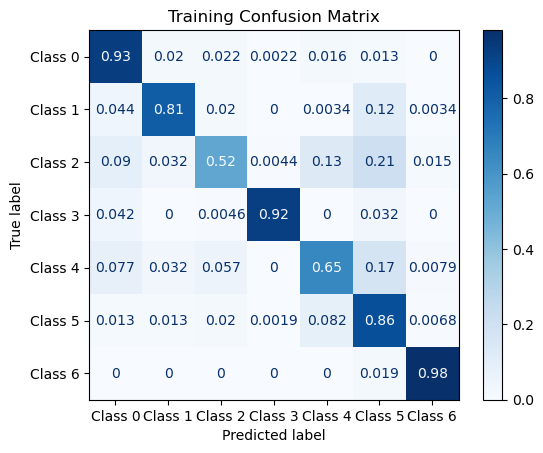


Classification Report:
Total accuracy: 0.7983512999365885

         Accuracy  Precision    Recall  F1-Score
Class 0  0.926339   0.719237  0.926339  0.809756
Class 1  0.810811   0.866426  0.810811  0.837696
Class 2  0.521866   0.792035  0.521866  0.629174
Class 3  0.921296   0.961353  0.921296  0.940898
Class 4  0.652174   0.550918  0.652174  0.597285
Class 5  0.863000   0.849478  0.863000  0.856186
Class 6  0.980952   0.872881  0.980952  0.923767


In [63]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, train_loader, class_names, title="Training Confusion Matrix")

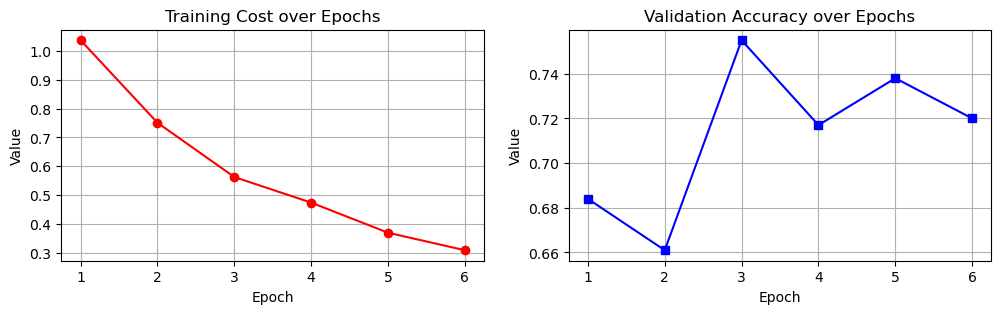

In [64]:
epochs_r = range(1, 6+1)
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(epochs_r, loss_list2, marker='o', label='Training Cost', color='red')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Cost over Epochs')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs_r, accuracy_list2, marker='s', label='Validation Accuracy', color='blue')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Testing the model [For Evaluators]

### Load the required libraries and classes

In [ ]:
import os
import copy
import time
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torchvision.io import read_image
torch.manual_seed(0)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        labels = []
        paths = []
        for file_name in os.listdir(img_dir):
            labels.append(int(file_name.split('_')[0]) - 1)
            paths.append(os.path.join(img_dir, file_name))
        
        self.img_labels = pd.DataFrame([paths, labels]).T
        del labels
        del paths

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label 

In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset, weights=None):
        self.dataset = dataset
        self.weights = np.array(weights)
        self.transform = dataset.transform
        self.target_transform = dataset.target_transform
        self.num_classes = len(self.dataset.img_labels[1].unique())
        
        if weights is None:
            self.weights = np.ones(self.num_classes, dtype=np.int8)
        if len(self.weights) != self.num_classes:
            raise ValueError("Expected {} weights. Provided {}. len(weights) should be equal to number of classes".
                             format(self.num_classes, len(self.weights)))

        labels = []
        paths = []
        df = self.dataset.img_labels
        for fpath, label in df.itertuples(index=False):
            for _ in range(self.weights[label]):
                paths.append(fpath)
                labels.append(label)
        
        self.img_labels = pd.DataFrame([paths, labels]).T

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Load the Test Dataset [Replace the Path]

In [ ]:
weights = models.MobileNet_V3_Large_Weights.IMAGENET1K_V2

# We are converting into RGB format as MobileNet expects 3 channel images.
data_transforms_test = {
    "test" : transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        weights.transforms()
    ])
}

In [ ]:
test_imgDataset = ImageDataset(img_dir="REPLACE-TEST-PATH-HERE", transform=data_transforms_test["test"])
test_dataset = AugmentedDataset(test_imgDataset)
test_loader = DataLoader(dataset=test_dataset, batch_size=25, shuffle=False)

In [ ]:
# Check if the dataset is loaded properly
print(test_dataset.img_labels[1].value_counts(sort=False))
print("Total Length: ", len(test_dataset))

### Load the defined Architecture 

In [ ]:
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The device type is:", device)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
n_classes = 7

model.features[16] = models.mobilenetv3.Conv2dNormActivation(
    in_channels = 160,
    out_channels = 800,
    kernel_size = 1,
    stride = 1,
    bias = False,
    # norm_layer = functools.partial(nn.BatchNorm2d, eps=0.001, momentum=0.01),
    activation_layer=lambda *args, **kwargs: nn.Hardswish()
)

model.classifier = nn.Sequential(
    nn.Linear(in_features=800, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1280, out_features=n_classes, bias=True)
)

### Load the best trained model [Replace Path Here]

In [ ]:
# Please use this model: model2_755Adam.pt
model.load_state_dict(torch.load("models_revamped/model_large_755Adam.pt", weights_only=True))
model = model.to(device)

### Results

In [ ]:
def evaluate(model, dataloader, class_names, title):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

    # Compute classification metrics
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    tot_acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

    print("\nClassification Report:")
    print(f"Total accuracy: {tot_acc}\n")
    print(pd.DataFrame([class_accuracy, precision, recall, f1], columns=class_names, index=["Accuracy", "Precision", "Recall", "F1-Score"]).T)

In [ ]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, test_loader, class_names, title="Test Confusion Matrix")

---
# Model 2

In [37]:
import os
import copy
import time
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [38]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torchvision.io import read_image
torch.manual_seed(0)

from google.colab import drive
drive.mount('/content/drive')

## Data Loading

In [39]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        labels = []
        paths = []
        for file_name in os.listdir(img_dir):
            labels.append(int(file_name.split('_')[0]) - 1)
            paths.append(os.path.join(img_dir, file_name))
        
        self.img_labels = pd.DataFrame([paths, labels]).T
        del labels
        del paths

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label   

In [40]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset, weights=None):
        self.dataset = dataset
        self.weights = np.array(weights)
        self.transform = dataset.transform
        self.target_transform = dataset.target_transform
        self.num_classes = len(self.dataset.img_labels[1].unique())
        
        if weights is None:
            self.weights = np.ones(self.num_classes, dtype=np.int8)
        if len(self.weights) != self.num_classes:
            raise ValueError("Expected {} weights. Provided {}. len(weights) should be equal to number of classes".
                             format(self.num_classes, len(self.weights)))

        labels = []
        paths = []
        df = self.dataset.img_labels
        for fpath, label in df.itertuples(index=False):
            for _ in range(self.weights[label]):
                paths.append(fpath)
                labels.append(label)
        
        self.img_labels = pd.DataFrame([paths, labels]).T

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [41]:
weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1

# We are converting into RGB format as MobileNet expects 3 channel images.
data_transforms = {"train" : transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation(degrees=20),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        weights.transforms()
    ]),
    "val" : transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        weights.transforms()
    ])
}

In [42]:
train_path = "/content/drive/MyDrive/train"
val_path = "/content/drive/MyDrive/val"

train_imgDataset = ImageDataset(img_dir=train_path, transform=data_transforms["train"])
valid_imgDataset = ImageDataset(img_dir=val_path, transform=data_transforms["val"])

In [43]:
train_imgDataset.img_labels[1].value_counts(sort=False)

1
0     112
1     148
2     343
3      36
4     253
5    2073
6      35
Name: count, dtype: int64

In [44]:
valid_imgDataset.img_labels[1].value_counts(sort=False)

1
0     36
1     60
2    102
3     15
4     97
5    670
6     20
Name: count, dtype: int64

In [45]:
print(len(train_imgDataset), len(valid_imgDataset))

3000 1000


In [49]:
label_weights = [4,4,2,6,2,1,6]
train_dataset = AugmentedDataset(train_imgDataset, weights=label_weights)
valid_dataset = AugmentedDataset(valid_imgDataset)

In [50]:
print(len(train_dataset), len(valid_dataset))

4731 1000


In [51]:
# train_dataset.img_labels.to_csv("AugmentedTrain.csv", index=False)
train_dataset.img_labels.iloc[2]

0    train\1_image_1014.jpg
1                         0
Name: 2, dtype: object

In [52]:
train_dataset.img_labels[1].value_counts(sort=False)

1
0     448
1     592
2     686
3     216
4     506
5    2073
6     210
Name: count, dtype: int64

In [53]:
train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=25, shuffle=True)
len(train_loader)

95

In [54]:
def imshow_(inp, title=None):
    inp = inp.permute(1, 2, 0).numpy()       # Permutes the dimensions of the image.
    inp = (inp - inp.min()) / (inp.max() - inp.min())
    print(inp.shape)
    
    plt.imshow(inp[:,:,0], cmap="gray")
    if title is not None:
        plt.title(title)
    # plt.pause(0.1)
    plt.show()

(224, 224, 3)


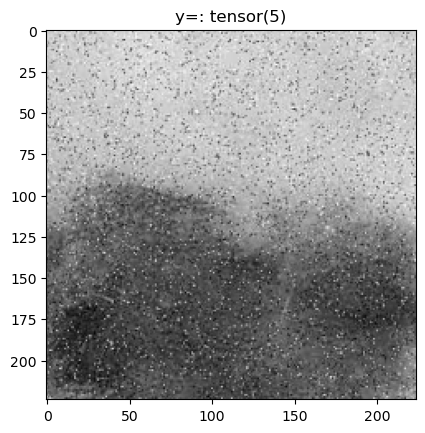

(224, 224, 3)


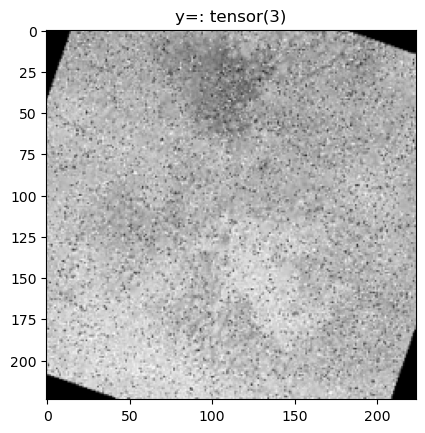

(224, 224, 3)


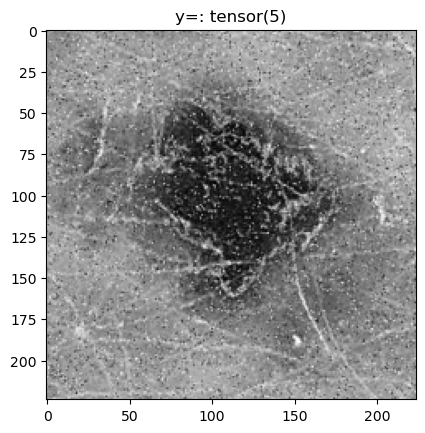

In [55]:
for x,y  in train_loader:
    for i in range(len(y)):
        imshow_(x[i],"y=: {}".format(str(y[i])))
        if i==2:
            break
    break

In [15]:
for images, labels in train_loader:
    print(images.shape, labels)
    break

torch.Size([50, 3, 224, 224]) tensor([4, 5, 1, 5, 5, 2, 4, 2, 5, 5, 5, 4, 5, 0, 4, 4, 1, 1, 5, 5, 5, 1, 1, 2,
        5, 5, 5, 2, 5, 0, 5, 5, 5, 5, 2, 1, 6, 5, 5, 5, 5, 0, 1, 4, 6, 2, 5, 0,
        5, 0])


## Training Model 2

### Hyperparameters

In [56]:
n_epochs = 15
batch_size = 50
lr = 0.001
n_classes = 7
momentum = 0.9

In [57]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=25, shuffle=True)

In [58]:
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The device type is:", device)

The device type is: cpu


In [60]:
for param in model.parameters():
    param.requires_grad = False

In [61]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

<b> NOTE: We can change the architecture by changing the parameters in the last layer </b>

In [62]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=576, out_features=1024, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1024, out_features=n_classes, bias=True)
)

In [63]:
model = model.to(device)

In [64]:
class_weights = torch.Tensor(1/train_dataset.img_labels[1].value_counts(sort=False, normalize=True))
class_weights/class_weights.min()


tensor([4.6272, 3.5017, 3.0219, 9.5972, 4.0968, 1.0000, 9.8714])

In [65]:
# class_weights = torch.Tensor([3, 2.2, 2, 5, 3, 1, 5])
class_weights = torch.Tensor([3, 3, 2, 5, 3, 1, 6])
class_weights = class_weights.to(device)
print(class_weights)

tensor([3., 3., 2., 5., 3., 1., 6.])


### Training only last 2 layers

In [26]:
criterion1 = nn.CrossEntropyLoss(weight=class_weights)
optimizer1 = torch.optim.Adam(model.parameters(), lr=lr)
scheduler1 = lr_scheduler.StepLR(optimizer1, step_size=3, gamma=0.5)

In [27]:
def train_model(model, train_loader,validation_loader, criterion, optimizer, n_epochs, scheduler=None, print_=True):
    loss_list = []
    accuracy_list = []
    models_list = []
    correct = 0
    n_test = len(validation_loader.dataset)
    accuracy_best=0
    train_cost_best = 2
    best_model_wts = copy.deepcopy(model.state_dict())

    # Loop through epochs
    for epoch in range(n_epochs):
        loss_sublist = []
        model.train()
        
        if print_:
            print(f"Learning rate for epoch {epoch+1}:", optimizer.param_groups[0]['lr'])
            
        # Loop through the data in loader
        for x, y in tqdm(train_loader):
            x, y=x.to(device), y.to(device)
            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_cost = np.mean(loss_sublist)
        loss_list.append(train_cost)
        
        correct = 0
        model.eval()
        print("Fetching validation results for epoch {} ...".format(epoch+1))

        with torch.no_grad():
            for x_test, y_test in validation_loader:
                x_test, y_test=x_test.to(device), y_test.to(device)
                z = model(x_test)
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == y_test).sum().item()
            accuracy = correct / n_test
            accuracy_list.append(accuracy)
        
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(accuracy)
            else:
                scheduler.step()
        
        if accuracy>accuracy_best:
            accuracy_best = accuracy
            train_cost_best = train_cost
            best_model_wts = copy.deepcopy(model.state_dict())
        elif accuracy == accuracy_best and train_cost < train_cost_best:
            train_cost_best = train_cost
            best_model_wts = copy.deepcopy(model.state_dict())
      
        if print_:
            print("The training cost for epoch " + str(epoch + 1) + ": " + str(train_cost))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy))
            print()
        models_list.append(copy.deepcopy(model.state_dict()))
    model.load_state_dict(best_model_wts)
    return accuracy_list, loss_list, model, models_list

In [28]:
start_datetime = datetime.now()
start_time=time.time()
print("Training started at:", datetime.now())

accuracy_list,loss_list, model, mod_list = train_model(model,train_loader , valid_loader, criterion1, optimizer1, scheduler=scheduler1, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("Elapsed time", elapsed_time )

Training started at: 2025-04-14 11:58:42.598035
Learning rate for epoch 1: 0.001


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:51<00:00,  1.97it/s]


Fetching validation results for epoch 1 ...
The training cost for epoch 1: 1.6276015668812365
The validation accuracy for epoch 1: 0.622

Learning rate for epoch 2: 0.001


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:56<00:00,  1.79it/s]


Fetching validation results for epoch 2 ...
The training cost for epoch 2: 1.4580955422750794
The validation accuracy for epoch 2: 0.491

Learning rate for epoch 3: 0.001


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:56<00:00,  1.78it/s]


Fetching validation results for epoch 3 ...
The training cost for epoch 3: 1.4548954102072384
The validation accuracy for epoch 3: 0.55

Learning rate for epoch 4: 0.0005


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:51<00:00,  1.97it/s]


Fetching validation results for epoch 4 ...
The training cost for epoch 4: 1.3766706916365292
The validation accuracy for epoch 4: 0.57

Learning rate for epoch 5: 0.0005


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:50<00:00,  1.99it/s]


Fetching validation results for epoch 5 ...
The training cost for epoch 5: 1.3716861812194976
The validation accuracy for epoch 5: 0.527

Learning rate for epoch 6: 0.0005


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:50<00:00,  2.00it/s]


Fetching validation results for epoch 6 ...
The training cost for epoch 6: 1.3195636756349318
The validation accuracy for epoch 6: 0.471

Learning rate for epoch 7: 0.00025


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:52<00:00,  1.94it/s]


Fetching validation results for epoch 7 ...
The training cost for epoch 7: 1.304330582665925
The validation accuracy for epoch 7: 0.565

Learning rate for epoch 8: 0.00025


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:51<00:00,  1.97it/s]


Fetching validation results for epoch 8 ...
The training cost for epoch 8: 1.2968064245611135
The validation accuracy for epoch 8: 0.575

Learning rate for epoch 9: 0.00025


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:50<00:00,  1.99it/s]


Fetching validation results for epoch 9 ...
The training cost for epoch 9: 1.2981619480812903
The validation accuracy for epoch 9: 0.608

Learning rate for epoch 10: 0.000125


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:50<00:00,  2.00it/s]


Fetching validation results for epoch 10 ...
The training cost for epoch 10: 1.3012879679698754
The validation accuracy for epoch 10: 0.578

Learning rate for epoch 11: 0.000125


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:50<00:00,  2.00it/s]


Fetching validation results for epoch 11 ...
The training cost for epoch 11: 1.2798827809862572
The validation accuracy for epoch 11: 0.558

Learning rate for epoch 12: 0.000125


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:51<00:00,  1.97it/s]


Fetching validation results for epoch 12 ...
The training cost for epoch 12: 1.2786802844245835
The validation accuracy for epoch 12: 0.544

Learning rate for epoch 13: 6.25e-05


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:50<00:00,  2.00it/s]


Fetching validation results for epoch 13 ...
The training cost for epoch 13: 1.2652546674898355
The validation accuracy for epoch 13: 0.573

Learning rate for epoch 14: 6.25e-05


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:51<00:00,  1.95it/s]


Fetching validation results for epoch 14 ...
The training cost for epoch 14: 1.2708964560291556
The validation accuracy for epoch 14: 0.57

Learning rate for epoch 15: 6.25e-05


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:49<00:00,  2.04it/s]


Fetching validation results for epoch 15 ...
The training cost for epoch 15: 1.2621663448834184
The validation accuracy for epoch 15: 0.564

Elapsed time 862.7547121047974


In [29]:
def evaluate(model, dataloader, class_names, title):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

    # Compute classification metrics
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    tot_acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

    print("\nClassification Report:")
    print(f"Total accuracy: {tot_acc}\n")
    print(pd.DataFrame([class_accuracy, precision, recall, f1], columns=class_names, index=["Accuracy", "Precision", "Recall", "F1-Score"]).T)

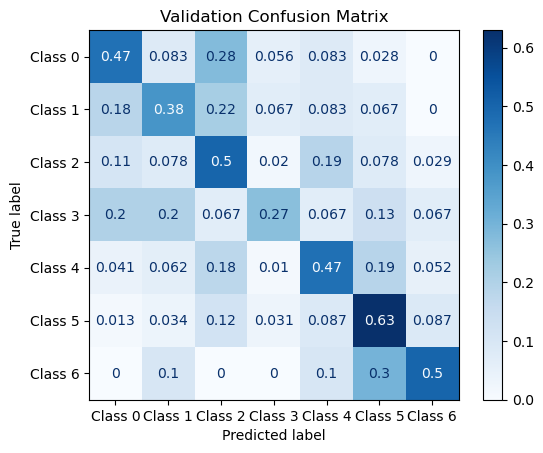


Classification Report:
Total accuracy: 0.573

         Accuracy  Precision    Recall  F1-Score
Class 0  0.472222   0.309091  0.472222  0.373626
Class 1  0.383333   0.338235  0.383333  0.359375
Class 2  0.500000   0.298246  0.500000  0.373626
Class 3  0.266667   0.117647  0.266667  0.163265
Class 4  0.474227   0.343284  0.474227  0.398268
Class 5  0.629851   0.915401  0.629851  0.746242
Class 6  0.500000   0.129870  0.500000  0.206186


In [31]:
model.load_state_dict(mod_list[12])
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, valid_loader, class_names, title="Validation Confusion Matrix")

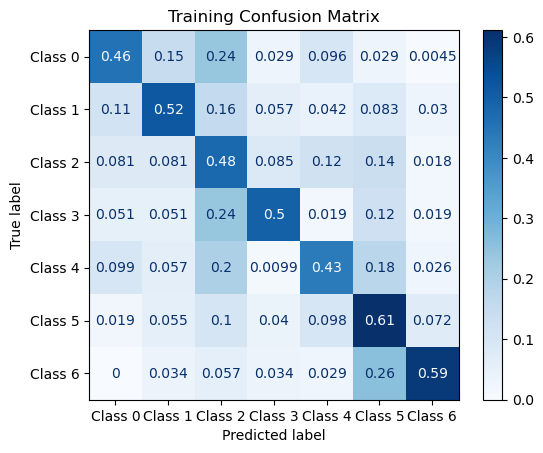


Classification Report:
Total accuracy: 0.5354236951776146

         Accuracy  Precision    Recall  F1-Score
Class 0  0.455357   0.448352  0.455357  0.451827
Class 1  0.516892   0.498371  0.516892  0.507463
Class 2  0.478134   0.458955  0.478134  0.468348
Class 3  0.495370   0.319403  0.495370  0.388385
Class 4  0.432806   0.350400  0.432806  0.387268
Class 5  0.611192   0.777301  0.611192  0.684310
Class 6  0.588571   0.334416  0.588571  0.426501


In [32]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, train_loader, class_names, title="Training Confusion Matrix")

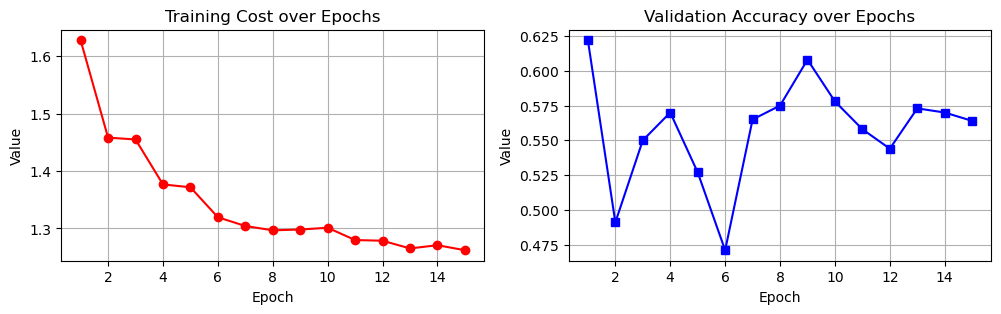

In [34]:
epochs_r = range(1, n_epochs+1)
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(epochs_r, loss_list, marker='o', label='Training Cost', color='red')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Cost over Epochs')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs_r, accuracy_list, marker='s', label='Validation Accuracy', color='blue')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Fine Tuning Model 2

In [33]:
model.load_state_dict(mod_list[12])
for param in model.parameters():
    param.requires_grad = True

In [34]:
class_weights = torch.Tensor([3, 3, 2, 5, 3, 1, 5])
class_weights = class_weights.to(device)

train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=25, shuffle=True)

In [41]:
criterion2 = nn.CrossEntropyLoss(weight=class_weights)
optimizer2 = torch.optim.Adam(model.parameters(), lr=lr/16)
# optimizer2 = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler2 = lr_scheduler.StepLR(optimizer2, step_size=3, gamma=0.5)

start_datetime = datetime.now()
start_time=time.time()
print("Training started at:", datetime.now())

accuracy_list2,loss_list2, model, mod_list2 = train_model(model,train_loader , valid_loader, criterion2, optimizer2, scheduler=scheduler2, n_epochs=6)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("Elapsed time", elapsed_time )

Training started at: 2025-04-14 14:16:44.253027
Learning rate for epoch 1: 6.25e-05


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:46<00:00,  1.05s/it]


Fetching validation results for epoch 1 ...
The training cost for epoch 1: 0.6543007696619129
The validation accuracy for epoch 1: 0.685

Learning rate for epoch 2: 6.25e-05


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:52<00:00,  1.11s/it]


Fetching validation results for epoch 2 ...
The training cost for epoch 2: 0.6143666853999147
The validation accuracy for epoch 2: 0.691

Learning rate for epoch 3: 6.25e-05


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:55<00:00,  1.14s/it]


Fetching validation results for epoch 3 ...
The training cost for epoch 3: 0.5761549139376914
The validation accuracy for epoch 3: 0.687

Learning rate for epoch 4: 3.125e-05


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:55<00:00,  1.14s/it]


Fetching validation results for epoch 4 ...
The training cost for epoch 4: 0.5431392219397101
The validation accuracy for epoch 4: 0.704

Learning rate for epoch 5: 3.125e-05


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:45<00:00,  1.04s/it]


Fetching validation results for epoch 5 ...
The training cost for epoch 5: 0.52612635316235
The validation accuracy for epoch 5: 0.691

Learning rate for epoch 6: 3.125e-05


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:48<00:00,  1.07s/it]


Fetching validation results for epoch 6 ...
The training cost for epoch 6: 0.5181950906125625
The validation accuracy for epoch 6: 0.693

Elapsed time 699.3681161403656


In [66]:
model.load_state_dict(mod_list2[3])
# torch.save(model.state_dict(), "models_revamped/model_small_700Adam.pt")

<All keys matched successfully>

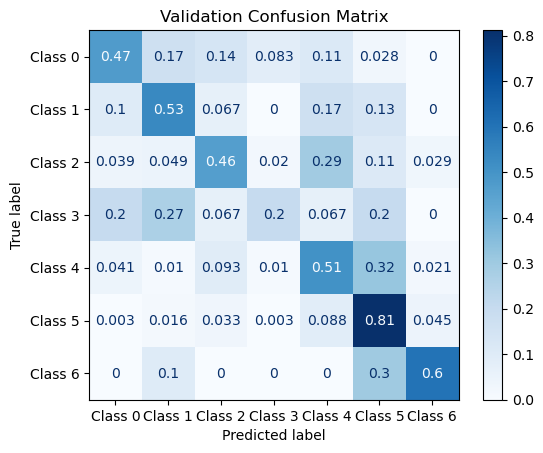


Classification Report:
Total accuracy: 0.704

         Accuracy  Precision    Recall  F1-Score
Class 0  0.472222   0.472222  0.472222  0.472222
Class 1  0.533333   0.524590  0.533333  0.528926
Class 2  0.460784   0.534091  0.460784  0.494737
Class 3  0.200000   0.272727  0.200000  0.230769
Class 4  0.505155   0.320261  0.505155  0.392000
Class 5  0.811940   0.900662  0.811940  0.854003
Class 6  0.600000   0.255319  0.600000  0.358209


In [67]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, valid_loader, class_names, title="Validation Confusion Matrix")

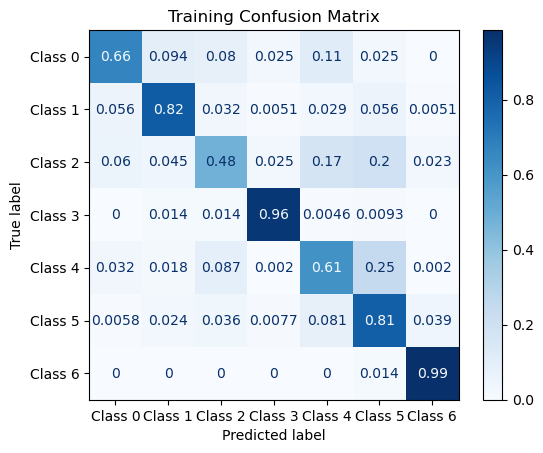


Classification Report:
Total accuracy: 0.740858169520186

         Accuracy  Precision    Recall  F1-Score
Class 0  0.662946   0.744361  0.662946  0.701299
Class 1  0.817568   0.781906  0.817568  0.799339
Class 2  0.476676   0.650099  0.476676  0.550042
Class 3  0.958333   0.811765  0.958333  0.878981
Class 4  0.612648   0.466165  0.612648  0.529462
Class 5  0.807043   0.844097  0.807043  0.825154
Class 6  0.985714   0.672078  0.985714  0.799228


In [68]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, train_loader, class_names, title="Training Confusion Matrix")

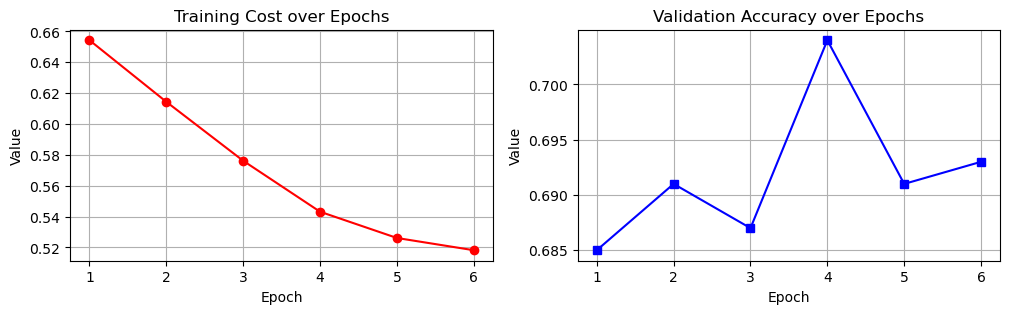

In [72]:
epochs_r = range(1, 6+1)
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(epochs_r, loss_list2, marker='o', label='Training Cost', color='red')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Cost over Epochs')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs_r, accuracy_list2, marker='s', label='Validation Accuracy', color='blue')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Testing the model [For Evaluators]

### Load the required libraries and classes

In [ ]:
import os
import copy
import time
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torchvision.io import read_image
torch.manual_seed(0)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        labels = []
        paths = []
        for file_name in os.listdir(img_dir):
            labels.append(int(file_name.split('_')[0]) - 1)
            paths.append(os.path.join(img_dir, file_name))
        
        self.img_labels = pd.DataFrame([paths, labels]).T
        del labels
        del paths

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label 

In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset, weights=None):
        self.dataset = dataset
        self.weights = np.array(weights)
        self.transform = dataset.transform
        self.target_transform = dataset.target_transform
        self.num_classes = len(self.dataset.img_labels[1].unique())
        
        if weights is None:
            self.weights = np.ones(self.num_classes, dtype=np.int8)
        if len(self.weights) != self.num_classes:
            raise ValueError("Expected {} weights. Provided {}. len(weights) should be equal to number of classes".
                             format(self.num_classes, len(self.weights)))

        labels = []
        paths = []
        df = self.dataset.img_labels
        for fpath, label in df.itertuples(index=False):
            for _ in range(self.weights[label]):
                paths.append(fpath)
                labels.append(label)
        
        self.img_labels = pd.DataFrame([paths, labels]).T

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Load the Test Dataset [Replace the Path]

In [ ]:
weights = models.MobileNet_V3_Large_Weights.IMAGENET1K_V2

# We are converting into RGB format as MobileNet expects 3 channel images.
data_transforms_test = {
    "test" : transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        weights.transforms()
    ])
}

In [ ]:
test_imgDataset = ImageDataset(img_dir="REPLACE-TEST-PATH-HERE", transform=data_transforms_test["test"])
test_dataset = AugmentedDataset(test_imgDataset)
test_loader = DataLoader(dataset=test_dataset, batch_size=25, shuffle=False)

In [ ]:
# Check if the dataset is loaded properly
print(test_dataset.img_labels[1].value_counts(sort=False))
print("Total Length: ", len(test_dataset))

### Load the defined Architecture 

In [ ]:
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The device type is:", device)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
n_classes = 7

model.classifier = nn.Sequential(
    nn.Linear(in_features=576, out_features=1024, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1024, out_features=n_classes, bias=True)
)

### Load the best trained model [Replace Path here]

In [ ]:
# Please use this model: model_small_704Adam.pt
model.load_state_dict(torch.load("models_revamped/model_small_704Adam.pt", weights_only=True))
model = model.to(device)

### Results

In [ ]:
def evaluate(model, dataloader, class_names, title):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

    # Compute classification metrics
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    tot_acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

    print("\nClassification Report:")
    print(f"Total accuracy: {tot_acc}\n")
    print(pd.DataFrame([class_accuracy, precision, recall, f1], columns=class_names, index=["Accuracy", "Precision", "Recall", "F1-Score"]).T)

In [ ]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, test_loader, class_names, title="Test Confusion Matrix")